## Описание проекта (металлургическая промышленность)

### Условие задачи
Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

### Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

В каждой таблице есть уникальный ключ эксперимента - key, по которому можно собрать информацию об условиях и параметрах каждого конкретного проводимого эксперимента.

## План действий

1) Посмотрим данные, взглянем на выбросы, нарисуем графики, проверим корреляцию. Возможно в данных есть неполные, неточные данные. Лишнее убирается;

2) Подготовим данные для джоина в одну таблицу для удобства машинного обучения;

3) Сделаю масштабирование;

4) Порежем данные на обучающую, тестовую и валидационную выборку 80% 10% 10%;

5) Обучим LightGBM и CatBoost, посмотрим где лучше MAE и скорость предсказания.

## Код работы

In [324]:
#Библиоттеки для анализа и графиков
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math

import datetime as dt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import lightgbm as lgb
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression


import catboost
from catboost import CatBoostRegressor

import sys



In [325]:
data_arc = pd.read_csv('final_steel/data_arc.csv')
data_bulk = pd.read_csv('final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('final_steel/data_gas.csv')
data_temp = pd.read_csv('final_steel/data_temp.csv')
data_wire = pd.read_csv('final_steel/data_wire.csv')
data_wire_time = pd.read_csv('final_steel/data_wire_time.csv')

#копируем даные в переменные чтобы не повредить оригинальные данные
arc = data_arc.copy()
bulk_time =  data_bulk_time.copy()
bulk = data_bulk.copy()
gas = data_gas.copy()
temp = data_temp.copy()
wire_time = data_wire_time.copy() 
wire = data_wire.copy()


### Исследование данных

Посмотрим на данные и построим графики

In [326]:
#функция быстрого анализа
def base_analys(df):
    print("Быстрый анализ:")
    print(df.info())
    print()
    print(df.shape)
    print()
    print("Количество уникальны key:", len(df['key'].unique()) )
    print()
    print("Дубликаты:", df.duplicated().sum())
    print()

####  `data_arc.csv` — данные об электродах;

In [327]:
base_analys(arc)
arc.head(10)

Быстрый анализ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

(14876, 5)

Количество уникальны key: 3214

Дубликаты: 0



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


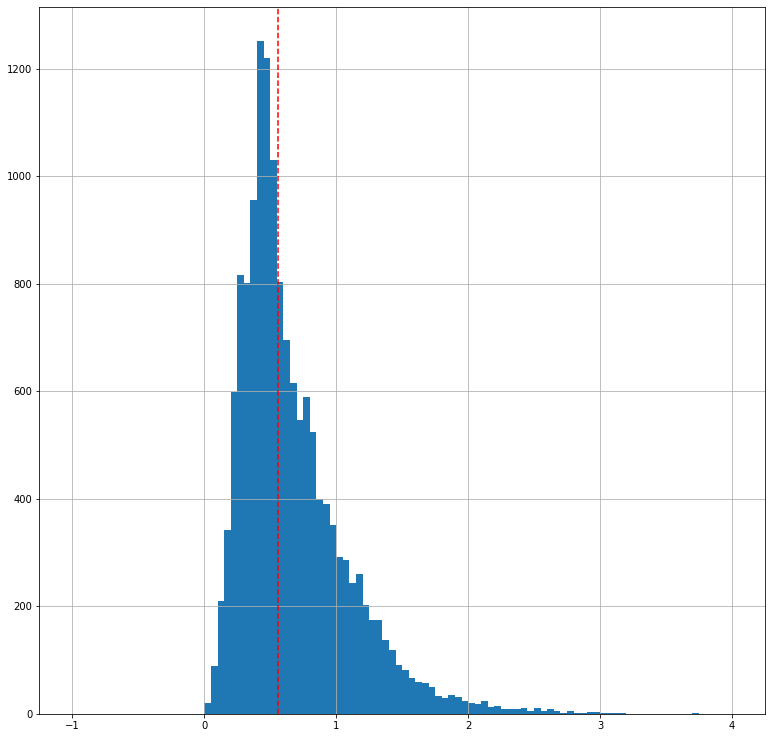

In [328]:
arc['Активная мощность'].hist(bins=100,range=(-1,4),figsize=(13,13)).axvline(arc['Активная мощность'].median(),color='r',linestyle='--')

min 0.0300019383
max 3.7315961123
median 0.5555174591500001


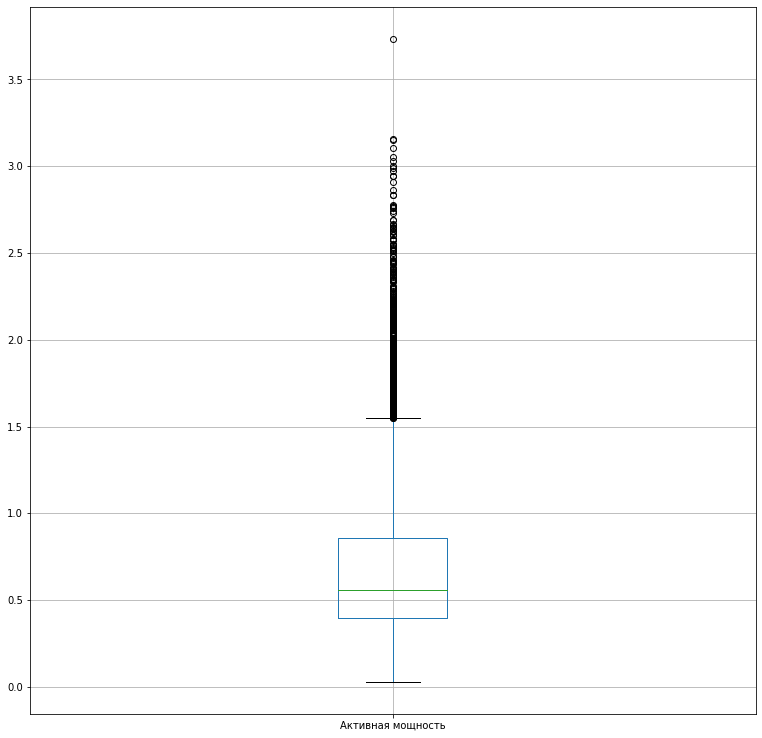

In [329]:
print("min", arc['Активная мощность'].min())
print("max",arc['Активная мощность'].max())
print("median", arc['Активная мощность'].median())

boxplot = arc.boxplot(column=['Активная мощность'],figsize=(13,13))
plt.show()

min -715.5049241780998
max 2.6763875484
median 0.41596150395


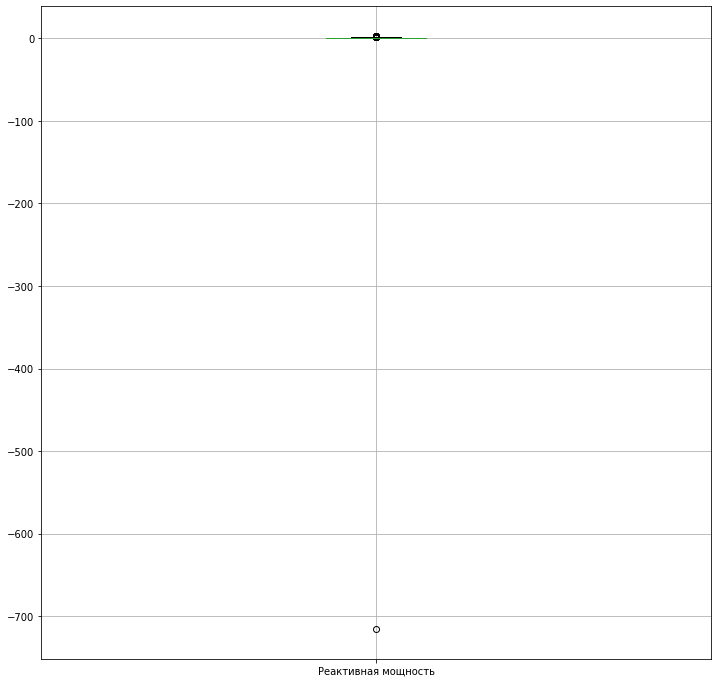

In [330]:
print("min", arc['Реактивная мощность'].min())
print("max",arc['Реактивная мощность'].max())
print("median", arc['Реактивная мощность'].median())

boxplot = arc.boxplot(column=['Реактивная мощность'],figsize=(12,12))
plt.show()

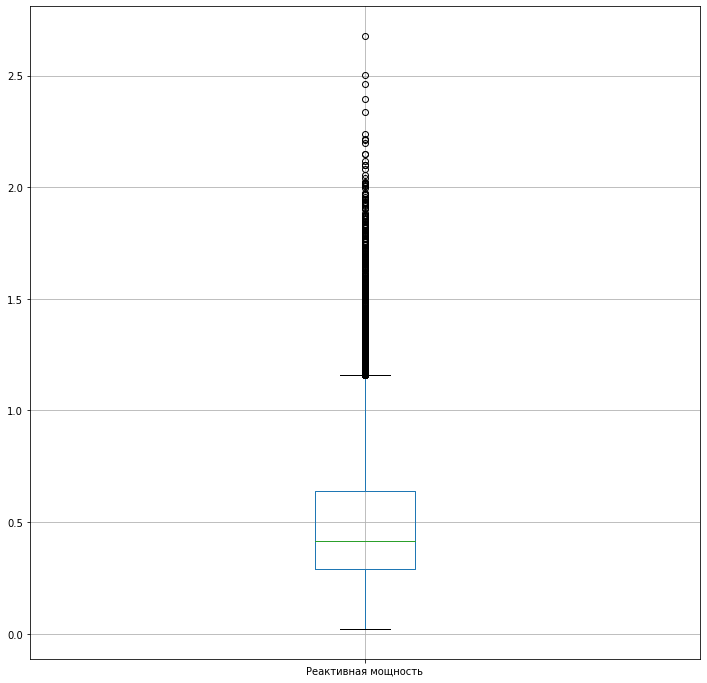

In [331]:
#тут найден сильный выброс не похожий на реальные данные, удален
arc = arc[(arc['Реактивная мощность'] > -600)]

boxplot = arc.boxplot(column=['Реактивная мощность'],figsize=(12,12))
plt.show()

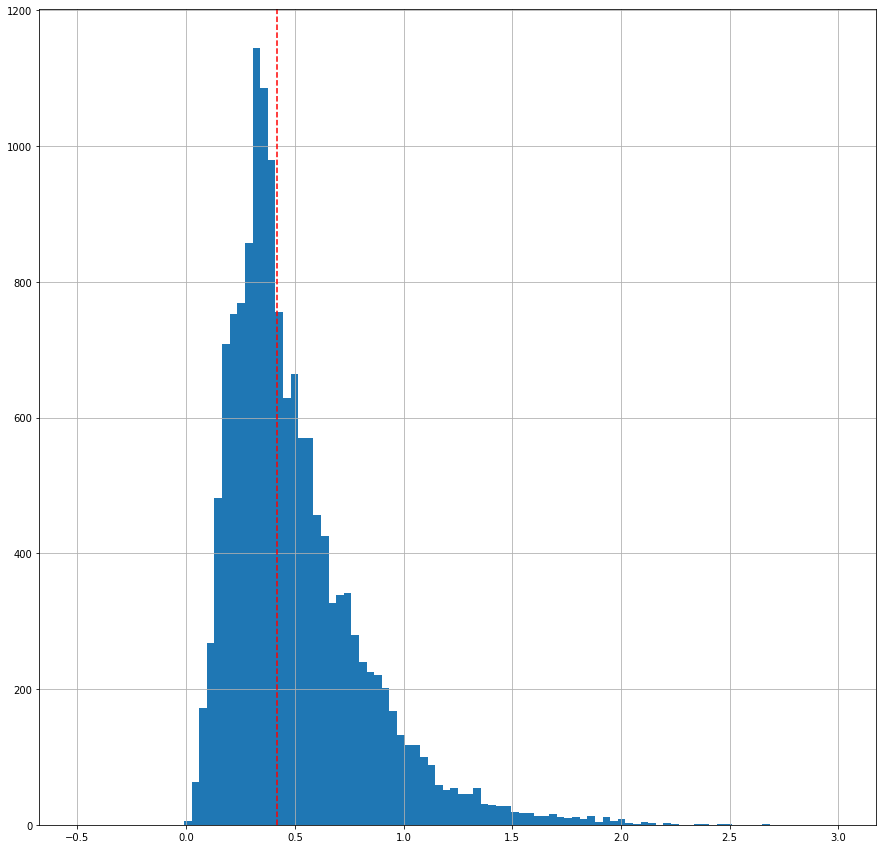

In [332]:
arc['Реактивная мощность'].hist(bins=100,range=(-0.5,3),figsize=(15,15)).axvline(arc['Реактивная мощность'].median(),color='r',linestyle='--')


In [333]:
#переименуем сразу
arc.rename(columns={'Активная мощность': 'act_pwr', 'Реактивная мощность': 'react_pwr'}, inplace=True)

####  `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);

bulk - масса

In [334]:
base_analys(bulk_time)
bulk_time.head(10)

Быстрый анализ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None

(3129, 16)

Количество уникальны key: 3129

Дубликаты: 0



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


####  `data_bulk.csv` — данные о подаче сыпучих материалов (объём);

In [335]:
base_analys(bulk)
bulk.head(20)


Быстрый анализ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None

(3129, 16)

Количество уникальны key: 3129

Дубликаты: 0



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


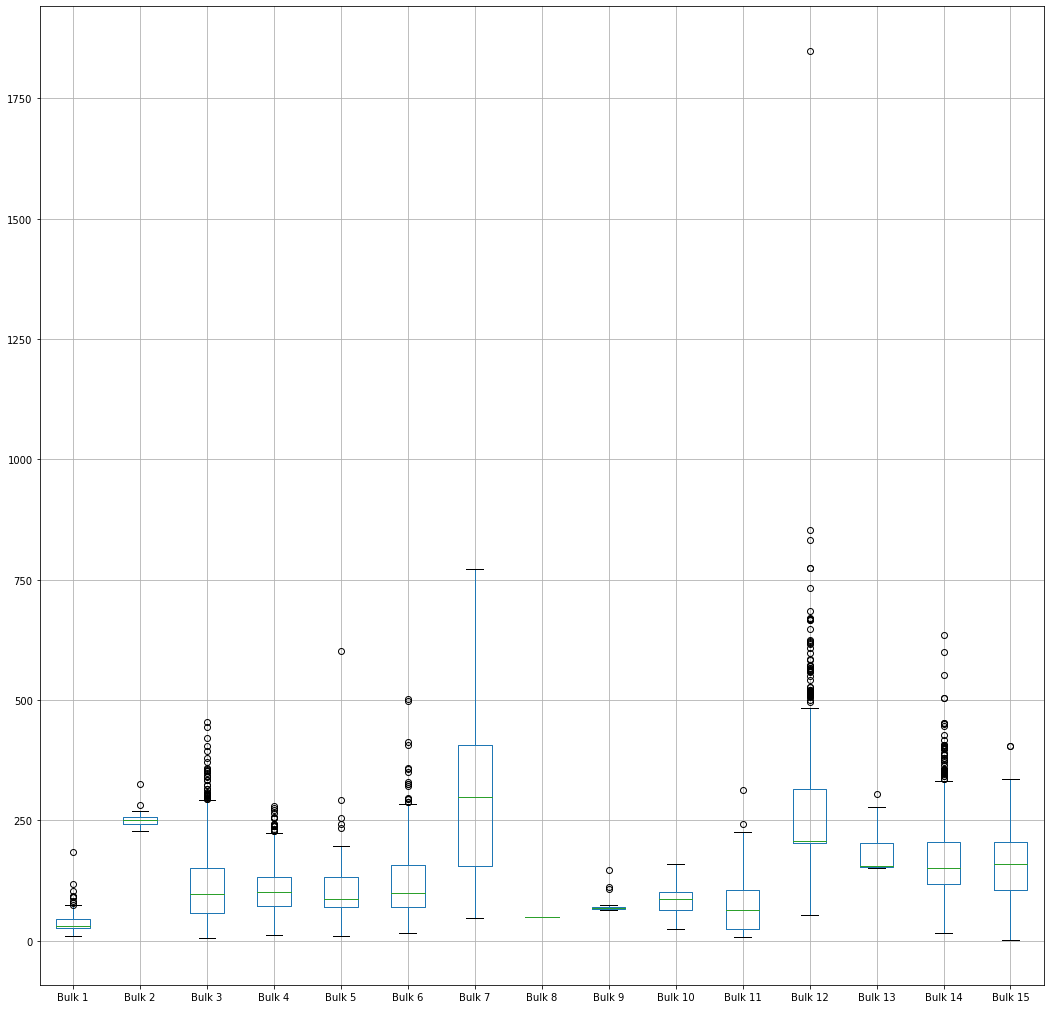

In [336]:
bulk_without_key = bulk.drop(['key'], axis=1)
boxpot = bulk_without_key 
boxpot.boxplot(figsize=(18,18))
del boxpot


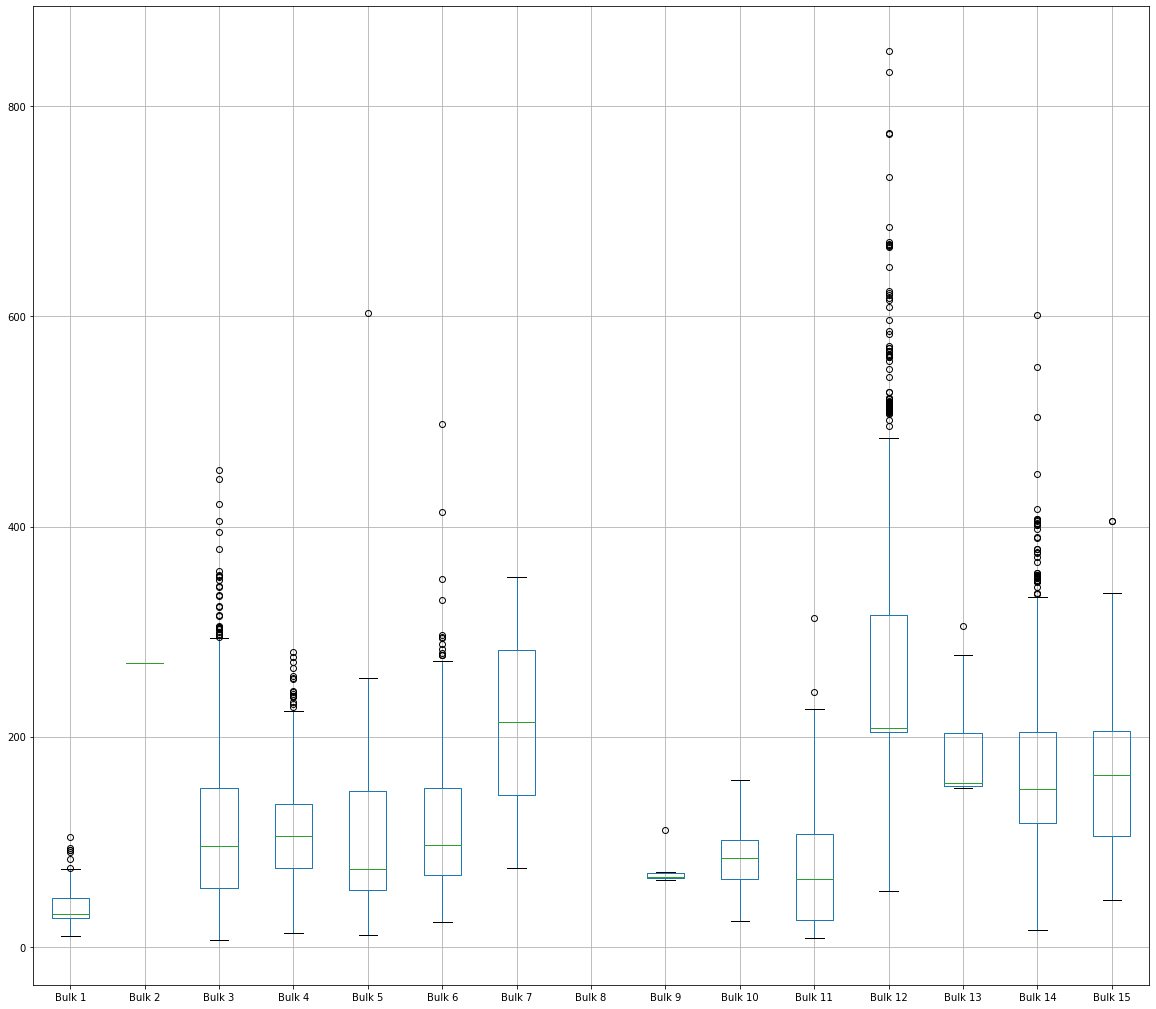

In [337]:
#уберем явные выбросы
bulk = bulk[(bulk['Bulk 12'] < 1750)]

bulk_without_key = bulk.drop(['key'], axis=1)
boxpot = bulk_without_key 
boxpot.boxplot(figsize=(20,18))

In [338]:
#скорректируем наны приравняем к нулю.
#способ странный но работает, видимо наны есть в key
bulk[['Bulk 1','Bulk 2','Bulk 3','Bulk 4',
     'Bulk 5','Bulk 6','Bulk 7','Bulk 8',
     'Bulk 9','Bulk 10','Bulk 11','Bulk 12',
     'Bulk 13','Bulk 14','Bulk 15']] = bulk[['Bulk 1','Bulk 2','Bulk 3','Bulk 4',
                                           'Bulk 5','Bulk 6','Bulk 7','Bulk 8',
                                           'Bulk 9','Bulk 10','Bulk 11','Bulk 12',
                                           'Bulk 13','Bulk 14','Bulk 15']].fillna(0)
bulk.tail(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3116,3229,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,128.0,206.0
3117,3230,0.0,0.0,132.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,130.0,204.0
3118,3231,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,258.0,0.0,130.0,204.0
3119,3232,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,92.0,204.0
3120,3233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,114.0,204.0
3122,3235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,118.0,206.0
3123,3236,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,258.0,0.0,132.0,208.0
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0


####  `data_gas.csv` — данные о продувке сплава газом;

In [339]:
base_analys(gas)

print("min", gas['Газ 1'].min())
print("max",gas['Газ 1'].max())
print("median", gas['Газ 1'].median())

print("NaNs in gas", gas['Газ 1'].isna().sum())
print

gas.head(10)

Быстрый анализ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

(3239, 2)

Количество уникальны key: 3239

Дубликаты: 0

min 0.0083985291
max 77.9950396623
median 9.836267334
NaNs in gas 0


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


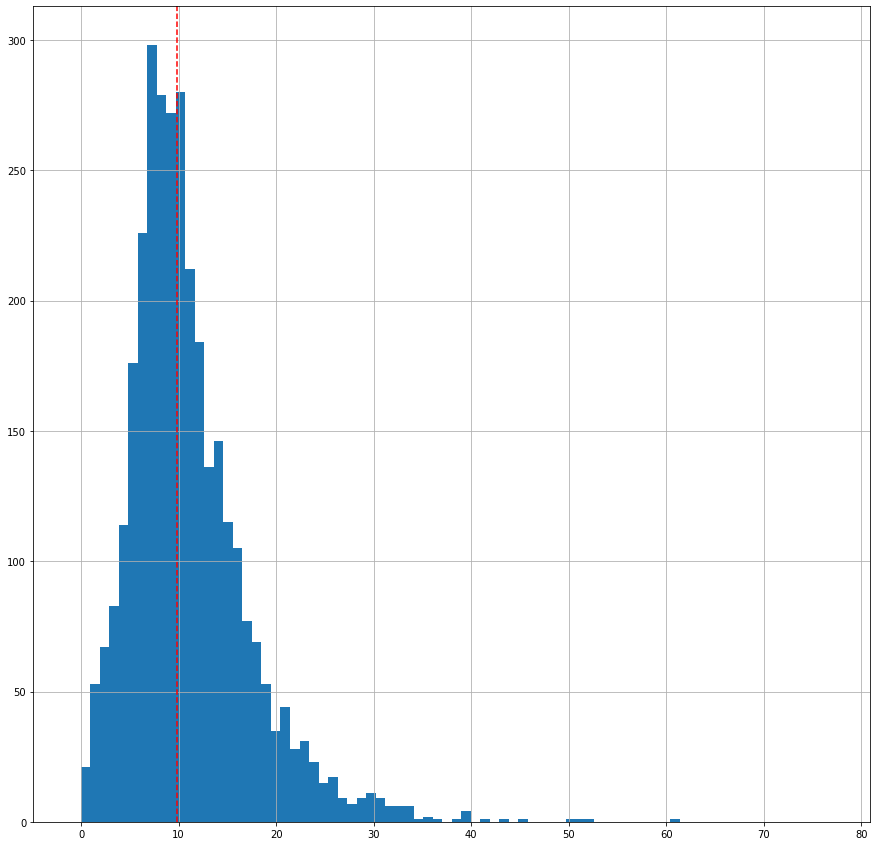

In [340]:
gas['Газ 1'].hist(bins=80,range=(-1,77),figsize=(15,15)).axvline(gas['Газ 1'].median(),color='r',linestyle='--')


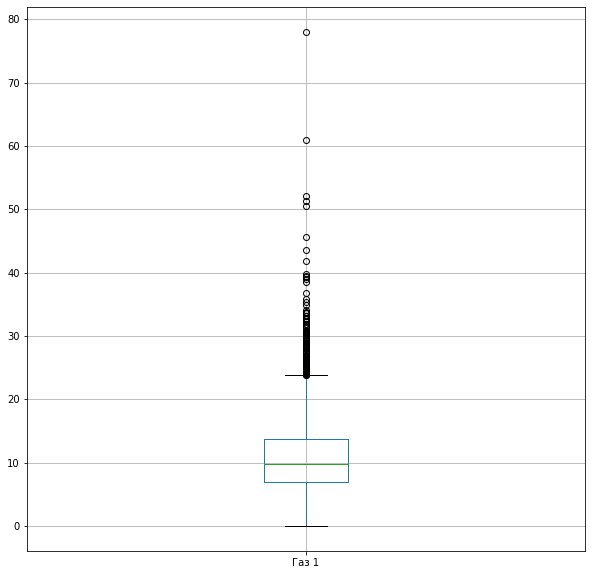

In [341]:
boxplot = gas.boxplot(column=['Газ 1'],figsize=(10,10))
plt.show()

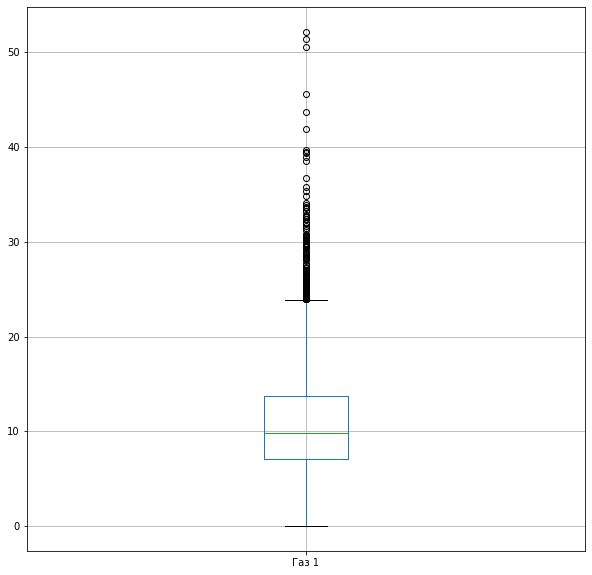

In [342]:
gas = gas[(gas['Газ 1'] < 60)]
boxplot = gas.boxplot(column=['Газ 1'],figsize=(10,10))
plt.show()


In [343]:
#переименуем газ
gas.rename(columns={'Газ 1':'gas_1',}, inplace=True)

####  `data_temp.csv` — результаты измерения температуры;

In [344]:
base_analys(temp)

print("min", temp['Температура'].min())
print("max",temp['Температура'].max())
print("median", temp['Температура'].median())
print("NaNs in gas", temp['Температура'].isna().sum())

temp.tail(20)

Быстрый анализ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None

(15907, 3)

Количество уникальны key: 3216

Дубликаты: 0

min 1191.0
max 1705.0
median 1591.0
NaNs in gas 2901


,key,Время замера,Температура
15887,3239,2019-09-01 01:42:46,NaN
15888,3239,2019-09-01 01:48:00,NaN
15889,3239,2019-09-01 01:59:27,NaN
15890,3239,2019-09-01 02:13:30,NaN
15891,3239,2019-09-01 02:22:15,NaN
15892,3239,2019-09-01 02:23:02,NaN
15893,3239,2019-09-01 02:24:15,NaN
15894,3240,2019-09-01 02:39:01,1617.0
15895,3240,2019-09-01 02:48:33,NaN
15896,3240,2019-09-01 03:03:21,NaN


Здесь имеются NaN. Удалим НаНы и посмотрим на сколько изменился процент данных.

In [345]:
temp.dropna(subset = ['Температура'], inplace = True)

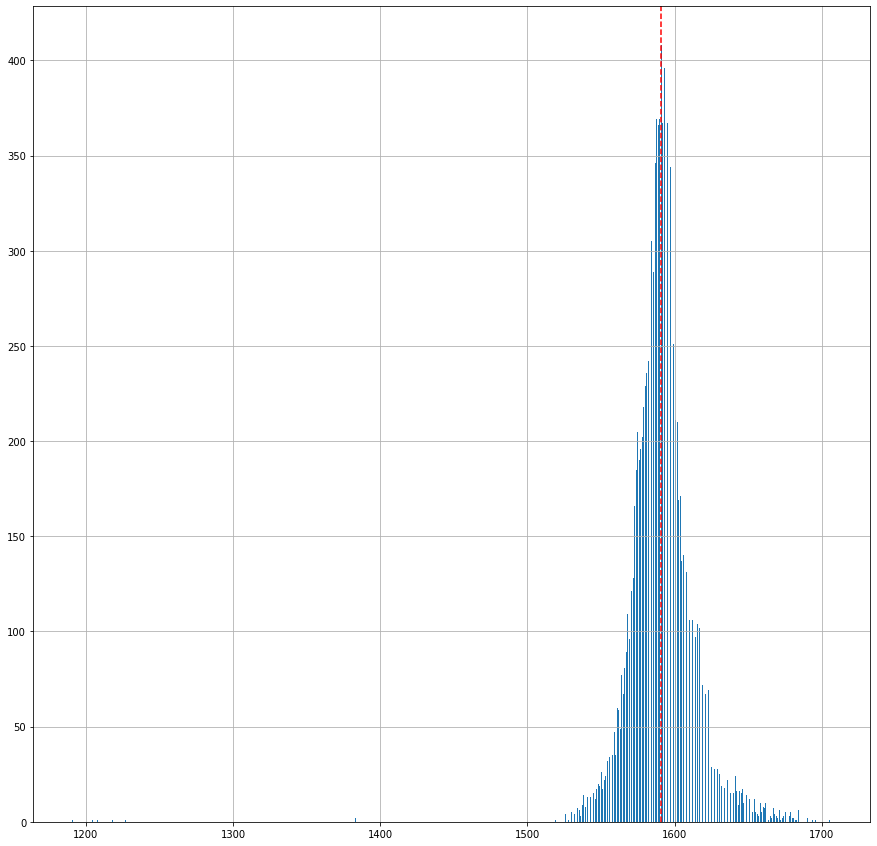

In [346]:
temp['Температура'].hist(bins=1000,
                         range=(1190,1707),
                         figsize=(15,15)).axvline(temp['Температура'].median(),color='r',linestyle='--')

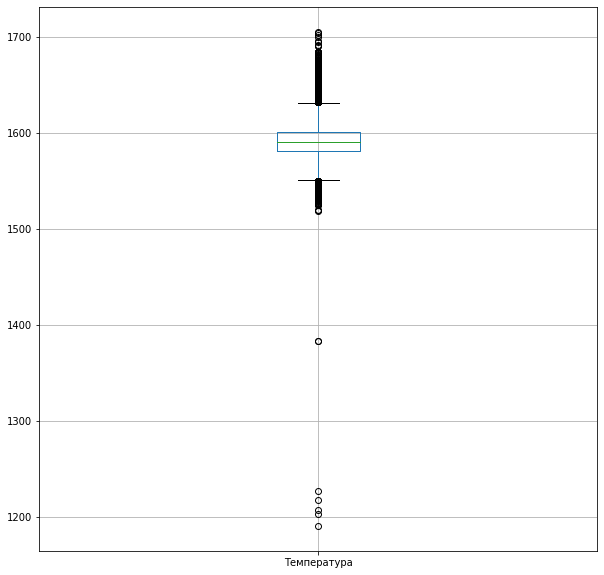

In [347]:
del boxplot
boxplot = temp.boxplot(column=['Температура'],figsize=(10,10))
plt.show()

In [348]:
print("min", temp['Температура'].min())
print("max",temp['Температура'].max())
print("median", temp['Температура'].median())
print("NaNs in gas", temp['Температура'].isna().sum())
print()
print(base_analys(temp))

temp.tail(10)

min 1191.0
max 1705.0
median 1591.0
NaNs in gas 0

Быстрый анализ:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
key             13006 non-null int64
Время замера    13006 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 406.4+ KB
None

(13006, 3)

Количество уникальны key: 3216

Дубликаты: 0

None


,key,Время замера,Температура
15857,3232,2019-08-31 19:55:53,1563.0
15862,3233,2019-08-31 20:24:14,1597.0
15866,3234,2019-08-31 20:54:17,1614.0
15869,3235,2019-08-31 21:31:47,1590.0
15874,3236,2019-08-31 22:08:13,1607.0
15878,3237,2019-08-31 22:44:04,1569.0
15883,3238,2019-08-31 23:30:31,1584.0
15886,3239,2019-09-01 01:31:47,1598.0
15894,3240,2019-09-01 02:39:01,1617.0
15902,3241,2019-09-01 04:03:30,1586.0


In [349]:
#Наблюдаются подозрительные выбросы с температурой ниже 1400. Судя по данным, у нас используются серьёзные металлы
#у которых медиана температуры равна 1591. Посмотрим количество данных, попавшее в выбросы.
low1450 = temp[temp['Температура'] <= 1400]
low1450

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


Данных не слишком много, удалим это, как выбросы. К тому-же встречается что-то похожее на дубли по ключам 8913 и 8914. Очень похоже на ошибки измерения и списывания у соседнего эксперимента. Причем не правильное списывание.

Быстрый анализ:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12999 entries, 0 to 15902
Data columns (total 3 columns):
key             12999 non-null int64
Время замера    12999 non-null object
Температура     12999 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 406.2+ KB
None

(12999, 3)

Количество уникальны key: 3215

Дубликаты: 0

None


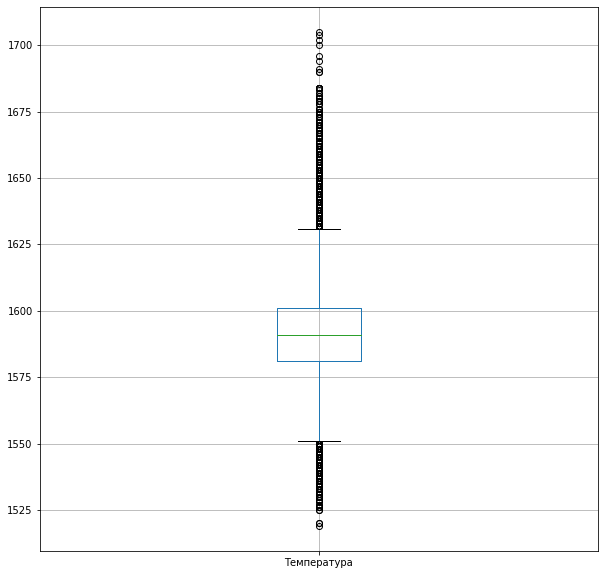

In [350]:
temp = temp[temp['Температура'] > 1400]
#посмотрим изменения после удаления

print(base_analys(temp))

del boxplot
boxplot = temp.boxplot(column=['Температура'],figsize=(10,10))
plt.show()

####  `data_wire_time.csv` — данные о проволочных материалах (время).

In [351]:
base_analys(wire_time)
wire_time.tail(20)

Быстрый анализ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

(3081, 10)

Количество уникальны key: 3081

Дубликаты: 0



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3061,3222,2019-08-31 12:11:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3062,3223,2019-08-31 13:13:32,2019-08-31 13:14:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3063,3224,2019-08-31 13:49:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3064,3225,2019-08-31 15:00:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3065,3226,2019-08-31 15:59:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3066,3227,2019-08-31 16:57:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3067,3228,2019-08-31 17:47:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3068,3229,2019-08-31 18:20:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3069,3230,2019-08-31 18:49:15,2019-08-31 18:50:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3070,3231,2019-08-31 19:26:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### `data_wire.csv` — данные о проволочных материалах (объём);

In [352]:
base_analys(wire)
wire.head(10)

Быстрый анализ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

(3081, 10)

Количество уникальны key: 3081

Дубликаты: 0



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


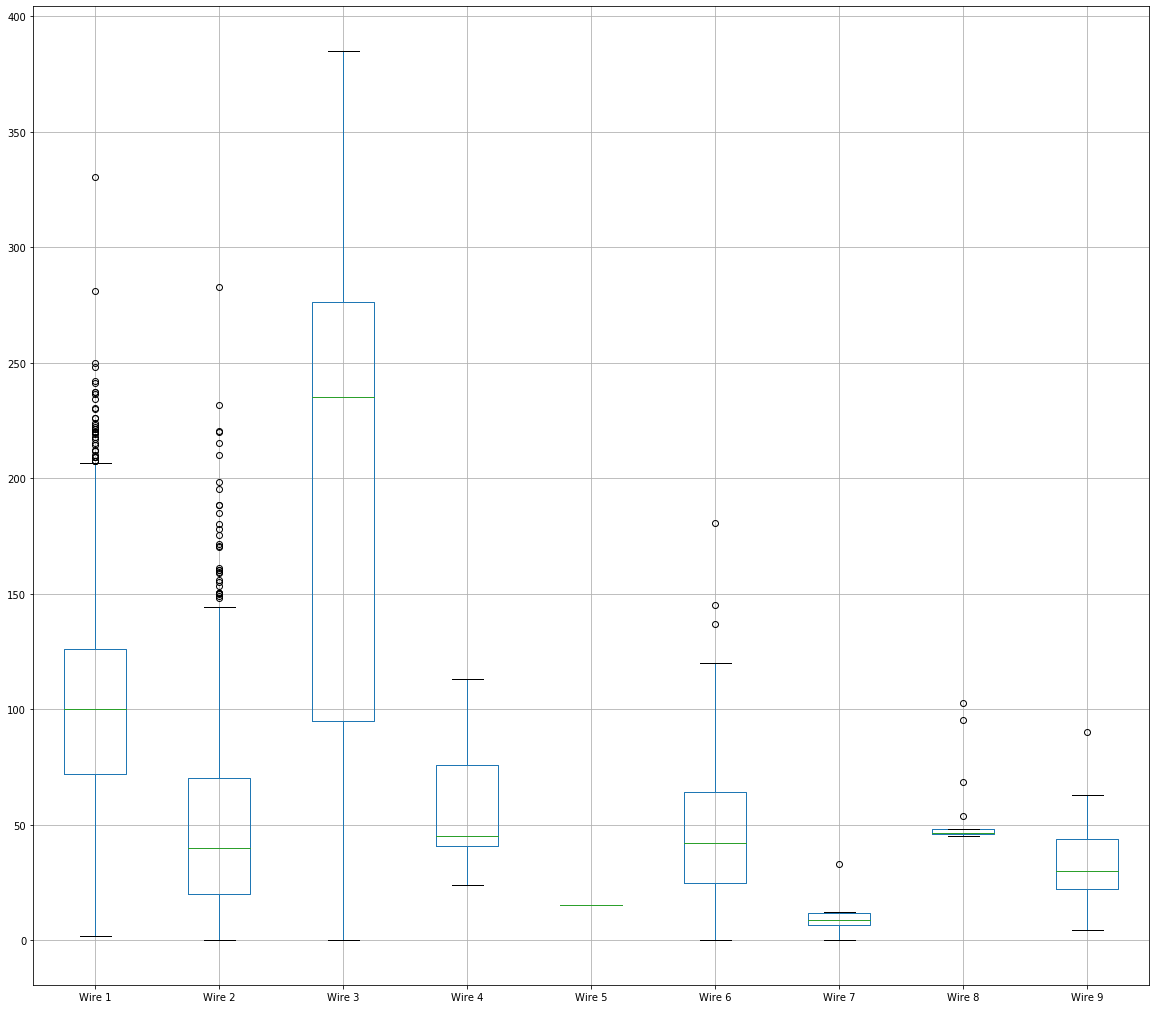

In [353]:
del boxpot
wire_without_key = wire.drop(['key'], axis=1)
boxpot = wire_without_key 
boxpot.boxplot(figsize=(20,18))


Заполняем наны нулями т.к. отсутствие данных говорит о том, что мы не получили в хоже эксперимента тот или иной Wire.
Машинное обучение же не любит NaN-ы.

In [354]:
wire = wire.fillna(value = 0)
wire.tail(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3071,3232,15.069600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3072,3233,107.147033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3073,3234,110.160957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3074,3235,125.099525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3075,3236,101.162880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3076,3237,38.088959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3080,3241,63.117595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### План предобработки данных:

- `data_arc.csv` — данные об электродах;<br>
удалю даты, тип нормальный

- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);<br>
забью NAN-ы нулями, затем джоин в таблицу

- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);<br>
не использую

- `data_gas.csv` — данные о продувке сплава газом;<br>
забью NAN-ы нулями, тип данных норм, затем джоин в таблицу

- `data_temp.csv` — результаты измерения температуры;<br>
удалю все кроме первой и последней температуры, затем джоин в таблицу

- `data_wire.csv` — данные о проволочных материалах (объём);<br>
забью NAN-ы нулями, тип данных норм, затем джоин в таблицу

- `data_wire_time.csv` — данные о проволочных материалах (время).<br>
не использую

### Подготовка данных

In [355]:
df_count_c = int(arc.groupby('key').agg({'Начало нагрева дугой': ['count']}).max())
df_count_c
#максимальное количество экспериментов за один key id

16

Преобразуем данные о нагреве. Для начала пронумеруем эксперименты на каждый key id:

In [356]:
%%time
numed_exp = pd.DataFrame(columns=('key','key_step'))

uniq_key_temp = list(arc['key'].unique())

for i in uniq_key_temp:
    key_df = arc[(arc['key'] == i)]
    count_key = int(key_df['key'].count())
    
    for j in range(1,count_key+1):
        row_exp = pd.Series(data={'key':int(i), 'key_step':int(j)})
        numed_exp = numed_exp.append(row_exp, ignore_index=True)

CPU times: user 16.4 s, sys: 26.3 ms, total: 16.4 s
Wall time: 16.4 s


In [357]:
arc['key_step'] = numed_exp['key_step']
#не большой костыль по закрыванию последнего key_step из NaN

pre_last_index = arc[arc==True].index[-3]
pre_last_row = arc.iloc[[pre_last_index]]
last_key_step = int(pre_last_row['key_step']+1)

arc['key_step'] = arc['key_step'].fillna(last_key_step)


In [358]:
arc

,key,Начало нагрева дугой,Конец нагрева дугой,act_pwr,react_pwr,key_step
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,2
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,3
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,4
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,5
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,2
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,3
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,4
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,5


Теперь определим формат данных времени для удобства дальнешей эксплуатации (общее время искать удобно).

grevd_time - время нагрева дугой (равное время конца-время начала), временная колонка.<br>
grevd_time_sec - тот же grevd_time, но мастабируемый по секундам.<br>

In [359]:
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

arc['grevd_time'] = arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']
arc['grevd_time_sec'] = arc['grevd_time'].dt.total_seconds().astype(int)
arc = arc.drop(['grevd_time'], axis=1)
arc.tail(10)

,key,Начало нагрева дугой,Конец нагрева дугой,act_pwr,react_pwr,key_step,grevd_time_sec
14866,3240,2019-09-01 02:35:24,2019-09-01 02:37:25,0.411601,0.274390,2,121
14867,3240,2019-09-01 02:40:55,2019-09-01 02:43:28,0.521811,0.378517,3,153
14868,3240,2019-09-01 03:08:38,2019-09-01 03:11:08,0.518065,0.528780,4,150
14869,3240,2019-09-01 03:12:34,2019-09-01 03:17:08,0.983723,0.884585,5,274
14870,3240,2019-09-01 03:31:47,2019-09-01 03:34:08,0.548882,0.416994,1,141
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,2,157
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,3,180
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,4,184
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,5,57
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708,6,81


In [360]:
#группируем данные, чтобы узнать сумму активной, реактивной мощности и общего времени потраченного за один key id
arc_pwr_grpby_sum = arc.groupby('key')['act_pwr','react_pwr','grevd_time_sec'].sum()
arc_pwr_grpby_sum.tail(10)

,act_pwr,react_pwr,grevd_time_sec
key,,,
3232,3.019208,2.188606,720
3233,1.602736,1.226234,409
3234,1.205073,0.854142,315
3235,2.464024,1.792177,595
3236,0.999742,0.852264,290
3237,3.932467,2.828459,909
3238,2.106529,1.681182,546
3239,4.666754,3.111617,1216
3240,2.984083,2.483267,839


In [361]:
#извлекаем фичу по количеству экспериментов на каждом key id (exp_count)
arc_pwr_grpby_sum['exp_count'] = arc.groupby('key')['key_step'].count()
arc_pwr_grpby_sum

,act_pwr,react_pwr,grevd_time_sec,exp_count
key,,,,
1,4.878147,3.183241,1098,5
2,3.052598,1.998112,811,4
3,2.525882,1.599076,655,5
4,3.209250,2.060298,741,4
5,3.347173,2.252643,869,4
...,...,...,...,...
3237,3.932467,2.828459,909,5
3238,2.106529,1.681182,546,3
3239,4.666754,3.111617,1216,8


In [362]:
#проверяем NaN, тут мне начали подсказывать, что отсутствуют некоторые данные
temp['Время замера'] = pd.to_datetime(temp['Время замера'], format='%Y-%m-%d %H:%M:%S')
print(temp.info())
print()

for i in temp:
    print(i, " ", temp[i].isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12999 entries, 0 to 15902
Data columns (total 3 columns):
key             12999 non-null int64
Время замера    12999 non-null datetime64[ns]
Температура     12999 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.2 KB
None

key   0
Время замера   0
Температура   0


Сделаем таблицу, где останется только первая температура и последняя температура (наша цель предсказания)

In [363]:
%%time
temp_first_and_last = pd.DataFrame(columns = ('key','first_temp','last_temp'))

uniq_key_temp = list(temp['key'].unique())

for i in uniq_key_temp:
    key_df = temp[(temp['key'] == i)]
    key_min = key_df['Время замера'].min()
    key_max = key_df['Время замера'].max()
    temp_f = float(key_df[(key_df['Время замера'] == key_min)]['Температура'])
    temp_l = float(key_df[(key_df['Время замера'] == key_max)]['Температура'])
    
    new_row = pd.Series(data={'key':int(i), 'first_temp':temp_f, 'last_temp':temp_l})

    temp_first_and_last = temp_first_and_last.append(new_row, ignore_index=True)


CPU times: user 7.91 s, sys: 10.4 ms, total: 7.92 s
Wall time: 7.92 s


In [364]:
temp_first_and_last['key'] = temp_first_and_last['key'].astype(int)
temp_first_and_last.head(10)

,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
5,6,1543.0,1596.0
6,7,1586.0,1599.0
7,8,1577.0,1598.0
8,9,1587.0,1592.0
9,10,1574.0,1593.0


### Объединение данных

#### Проверка данных в стиле SQL
Вставьте сюда key id и последующие строчки покажут, что есть по этому ключу:

In [365]:
key = 2108
#смотрел на него ибо самый большой эксперимент, потом пробовал из значений сделать фичи, 
#но это не сильно повлияло на качество, от идеи пришлось отказаться

In [366]:
arc[(arc['key'] == key)]


,key,Начало нагрева дугой,Конец нагрева дугой,act_pwr,react_pwr,key_step,grevd_time_sec
9734,2108,2019-07-23 14:05:57,2019-07-23 14:08:12,0.442274,0.327734,1,135
9735,2108,2019-07-23 14:32:08,2019-07-23 14:33:35,0.334060,0.273037,2,87
9736,2108,2019-07-23 14:38:21,2019-07-23 14:39:16,0.242396,0.171868,3,55
9737,2108,2019-07-23 14:40:29,2019-07-23 14:41:29,0.252583,0.191510,4,60
9738,2108,2019-07-23 14:44:10,2019-07-23 14:46:08,0.487753,0.375812,5,118
9739,2108,2019-07-23 14:47:56,2019-07-23 14:50:51,0.762996,0.580148,6,175
9740,2108,2019-07-23 17:04:16,2019-07-23 17:07:58,0.748764,0.573281,7,222
9741,2108,2019-07-23 17:10:03,2019-07-23 17:13:03,0.705522,0.696271,8,180
9742,2108,2019-07-23 17:14:20,2019-07-23 17:22:24,1.914019,1.932725,9,484
9743,2108,2019-07-23 17:23:04,2019-07-23 17:27:05,0.854662,1.031376,10,241


In [367]:
arc_pwr_grpby_sum[(arc_pwr_grpby_sum.index == key)]

,act_pwr,react_pwr,grevd_time_sec,exp_count
key,,,,
2108,10.426942,10.072821,2739,16


In [368]:
bulk_time[(bulk_time['key'] == key)]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2036,2108,2019-07-23 14:35:55,2019-07-23 14:35:55,NaN,2019-07-23 14:37:23,2019-07-23 14:35:55,NaN,2019-07-23 14:35:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [369]:
bulk[(bulk['key'] == key)]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15


In [370]:
gas[(gas['key'] == key)]

,key,gas_1
2105,2108,45.638999


In [371]:
temp[(temp['key'] == key)]


,key,Время замера,Температура
10407,2108,2019-07-23 14:09:40,1639.0
10408,2108,2019-07-23 14:16:34,1626.0
10409,2108,2019-07-23 14:43:57,1604.0
10410,2108,2019-07-23 14:47:45,1612.0
10411,2108,2019-07-23 14:51:37,1621.0
10412,2108,2019-07-23 17:09:27,1535.0
10413,2108,2019-07-23 17:22:53,1577.0
10414,2108,2019-07-23 17:27:38,1585.0
10415,2108,2019-07-23 18:37:14,1559.0
10416,2108,2019-07-23 18:42:58,1562.0


In [372]:
#wire_time[(wire_time['key'] == key)]


In [373]:
wire[(wire['key'] == key)]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2010,2108,11.05104,0.0,93.213127,92.570401,0.0,63.045845,1.053936,0.0,0.0


Замечен не совсем очевидный момент По обсуждению с заказчиком мы поняли, что нельзя брать промежуточную темературу, однако всегда после "Конца нагрева дугой" в arc идет замер в таблице temp. Заметил это примерно на пяти случайных ключах эксперимента.
Что логично: эксперимент провел - замерь.

Получается, что нам важны процедуры и замеры, но берем мы только первую и последнюю температуры.


#### Мерджи и джойны данных

Мерджим и джойним данные через "left", все что есть к новоиспеченным фичам arc_pwr_grpby_sum

In [374]:
join1 = arc_pwr_grpby_sum.merge(bulk, on='key', how='left')
join1.tail(5)

,key,act_pwr,react_pwr,grevd_time_sec,exp_count,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3209,3237,3.932467,2.828459,909,5,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3210,3238,2.106529,1.681182,546,3,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3211,3239,4.666754,3.111617,1216,8,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3212,3240,2.984083,2.483267,839,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3213,3241,2.471447,1.696199,659,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [375]:
join2 = join1.merge(wire, on='key', how='left')

In [376]:
join2.tail(10)

,key,act_pwr,react_pwr,grevd_time_sec,exp_count,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3204,3232,3.019208,2.188606,720,4,0.0,0.0,22.0,0.0,0.0,...,204.0,15.069600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3205,3233,1.602736,1.226234,409,3,0.0,0.0,0.0,0.0,0.0,...,204.0,107.147033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3206,3234,1.205073,0.854142,315,2,NaN,NaN,NaN,NaN,NaN,...,NaN,110.160957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3207,3235,2.464024,1.792177,595,4,0.0,0.0,0.0,0.0,0.0,...,206.0,125.099525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3208,3236,0.999742,0.852264,290,2,0.0,0.0,42.0,0.0,0.0,...,208.0,101.162880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3209,3237,3.932467,2.828459,909,5,0.0,0.0,170.0,0.0,0.0,...,206.0,38.088959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3210,3238,2.106529,1.681182,546,3,0.0,0.0,126.0,0.0,0.0,...,106.0,56.128799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3211,3239,4.666754,3.111617,1216,8,0.0,0.0,0.0,0.0,0.0,...,88.0,143.357761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3212,3240,2.984083,2.483267,839,5,NaN,NaN,NaN,NaN,NaN,...,NaN,34.070400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3213,3241,2.471447,1.696199,659,5,NaN,NaN,NaN,NaN,NaN,...,NaN,63.117595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [377]:
join3 = join2.merge(gas, on='key', how='left')

In [378]:
join3.head(10)

,key,act_pwr,react_pwr,grevd_time_sec,exp_count,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas_1
0,1,4.878147,3.183241,1098,5,0.0,0.0,0.0,43.0,0.0,...,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,3.052598,1.998112,811,4,0.0,0.0,0.0,73.0,0.0,...,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,2.525882,1.599076,655,5,0.0,0.0,0.0,34.0,0.0,...,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,3.209250,2.060298,741,4,0.0,0.0,0.0,81.0,0.0,...,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,3.347173,2.252643,869,4,0.0,0.0,0.0,78.0,0.0,...,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
5,6,3.955108,2.689175,952,4,0.0,0.0,0.0,117.0,0.0,...,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.273392
6,7,2.547375,1.561295,673,4,0.0,0.0,0.0,117.0,0.0,...,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.836267
7,8,3.762755,2.680698,913,4,0.0,0.0,0.0,99.0,0.0,...,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.171553
8,9,2.081951,1.478671,625,5,0.0,0.0,0.0,117.0,0.0,...,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.216623
9,10,2.923622,2.496116,825,6,0.0,0.0,0.0,0.0,0.0,...,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.529891


In [379]:
matrx = join3.merge(temp_first_and_last, on='key', how='left')
matrx.head(5)


,key,act_pwr,react_pwr,grevd_time_sec,exp_count,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas_1,first_temp,last_temp
0,1,4.878147,3.183241,1098,5,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571.0,1613.0
1,2,3.052598,1.998112,811,4,0.0,0.0,0.0,73.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581.0,1602.0
2,3,2.525882,1.599076,655,5,0.0,0.0,0.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1596.0,1599.0
3,4,3.209250,2.060298,741,4,0.0,0.0,0.0,81.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1601.0,1625.0
4,5,3.347173,2.252643,869,4,0.0,0.0,0.0,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1576.0,1602.0


In [380]:
matrx.tail(10)

,key,act_pwr,react_pwr,grevd_time_sec,exp_count,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas_1,first_temp,last_temp
3204,3232,3.019208,2.188606,720,4,0.0,0.0,22.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.630453,1563.0,1563.0
3205,3233,1.602736,1.226234,409,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.366606,1597.0,1597.0
3206,3234,1.205073,0.854142,315,2,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.110702,1614.0,1614.0
3207,3235,2.464024,1.792177,595,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.710729,1590.0,1590.0
3208,3236,0.999742,0.852264,290,2,0.0,0.0,42.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.958647,1607.0,1607.0
3209,3237,3.932467,2.828459,909,5,0.0,0.0,170.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.543905,1569.0,1569.0
3210,3238,2.106529,1.681182,546,3,0.0,0.0,126.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.745669,1584.0,1584.0
3211,3239,4.666754,3.111617,1216,8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.023518,1598.0,1598.0
3212,3240,2.984083,2.483267,839,5,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.863103,1617.0,1617.0
3213,3241,2.471447,1.696199,659,5,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.680959,1586.0,1586.0


Если посмотреть в начало таблицы, то все очень даже не плохо, но если посмотреть в хвост преобразований и имеющихся исходных таблиц, то постоянно находятся ошибки и недочеты в значения. 

In [381]:
#проверим на наличие NaN. NaN может возникнуть из-за нехватки данных  после джоина.
for i in matrx:
    print(i, " ", matrx[i].isna().sum())

key   0
act_pwr   0
react_pwr   0
grevd_time_sec   0
exp_count   0
Bulk 1   765
Bulk 2   765
Bulk 3   765
Bulk 4   765
Bulk 5   765
Bulk 6   765
Bulk 7   765
Bulk 8   765
Bulk 9   765
Bulk 10   765
Bulk 11   765
Bulk 12   765
Bulk 13   765
Bulk 14   765
Bulk 15   765
Wire 1   134
Wire 2   134
Wire 3   134
Wire 4   134
Wire 5   134
Wire 6   134
Wire 7   134
Wire 8   134
Wire 9   134
gas_1   4
first_temp   1
last_temp   1


In [382]:
matrx[matrx['Wire 9'].isna()]

,key,act_pwr,react_pwr,grevd_time_sec,exp_count,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas_1,first_temp,last_temp
48,51,5.684714,3.827727,1293,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.236758,1619.0,1690.0
49,52,5.052815,3.541881,1416,6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.119615,1617.0,1669.0
50,53,4.702678,3.418523,1048,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.090307,1642.0,1671.0
51,54,3.904337,2.629938,877,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.547380,1630.0,1663.0
52,55,4.598867,3.105961,1021,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.915683,1615.0,1654.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010,3036,4.554396,3.268760,1043,4,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.121872,1638.0,1638.0
3011,3037,2.711054,1.915579,625,3,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.410634,1650.0,1650.0
3012,3038,2.137680,1.589902,509,3,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.574384,1651.0,1651.0
3013,3039,2.061354,1.555513,487,3,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.257413,1645.0,1645.0


Если в Джоинах встречаются NaN то, для машинного обучнения это может быть проблемой.
Встречаются отсутствие данных по добавкам и по проволочным материалам. Найдены одинаковые темературы fist_temp и last_temp, что может запутать модель машинного обучения и искомый результат не удастся получить (проверенно на 5 часовом обучении на видеокартах).

In [383]:
matrx = matrx.dropna()
print(matrx.shape)
matrx.tail(10)

(2353, 32)


,key,act_pwr,react_pwr,grevd_time_sec,exp_count,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas_1,first_temp,last_temp
3201,3229,2.792553,2.055957,671,3,0.0,0.0,70.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.471095,1576.0,1576.0
3202,3230,3.041399,2.346321,727,3,0.0,0.0,132.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.822027,1580.0,1580.0
3203,3231,4.100369,3.039625,930,6,0.0,0.0,114.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.563350,1553.0,1553.0
3204,3232,3.019208,2.188606,720,4,0.0,0.0,22.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.630453,1563.0,1563.0
3205,3233,1.602736,1.226234,409,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.366606,1597.0,1597.0
3207,3235,2.464024,1.792177,595,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.710729,1590.0,1590.0
3208,3236,0.999742,0.852264,290,2,0.0,0.0,42.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.958647,1607.0,1607.0
3209,3237,3.932467,2.828459,909,5,0.0,0.0,170.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.543905,1569.0,1569.0
3210,3238,2.106529,1.681182,546,3,0.0,0.0,126.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.745669,1584.0,1584.0
3211,3239,4.666754,3.111617,1216,8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.023518,1598.0,1598.0


In [384]:
matrx = matrx[matrx['first_temp']!= matrx['last_temp']]
print(matrx.shape)
matrx.tail(10)

(1782, 32)


,key,act_pwr,react_pwr,grevd_time_sec,exp_count,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas_1,first_temp,last_temp
2465,2489,1.019340,1.001605,308,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.772628,1613.0,1579.0
2466,2490,4.169458,3.131572,992,5,0.0,0.0,50.0,116.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.019526,1602.0,1619.0
2467,2492,2.571284,1.934253,682,3,0.0,0.0,74.0,198.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.375063,1618.0,1595.0
2468,2493,1.627279,1.345660,405,3,0.0,0.0,115.0,105.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.421691,1599.0,1594.0
2469,2494,2.499038,1.756000,550,3,0.0,0.0,0.0,162.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.983053,1585.0,1591.0
2470,2495,3.210690,2.360777,723,4,0.0,0.0,21.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735,1570.0,1591.0
2471,2496,4.203064,2.810185,940,6,0.0,0.0,0.0,63.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616,1554.0,1591.0
2472,2497,2.212379,1.851269,569,3,0.0,0.0,0.0,85.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699,1571.0,1589.0
2473,2498,3.408725,2.355428,750,5,0.0,0.0,90.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657,1591.0,1594.0
2474,2499,4.098431,2.777865,883,4,0.0,0.0,47.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.336151,1569.0,1603.0


(2354, 32) против (1783, 32)

Таким образом удалось найти 571 эксперимент, где первая температура равна последней.

### Проверка мультикоррелиарности

In [385]:
matrx.corr()

,key,act_pwr,react_pwr,grevd_time_sec,exp_count,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas_1,first_temp,last_temp
key,1.000000,-0.029408,0.011774,-0.031568,-0.039996,-0.068433,NaN,-0.010992,-0.028592,0.023240,...,-0.062584,NaN,NaN,-0.015535,NaN,-0.061077,0.011572,-0.054431,-0.022433,-0.080832
act_pwr,-0.029408,1.000000,0.954337,0.974569,0.731723,0.017237,NaN,0.105405,-0.047704,-0.020304,...,0.012308,NaN,NaN,0.038711,NaN,0.001468,-0.001684,0.349847,-0.426072,0.316265
react_pwr,0.011774,0.954337,1.000000,0.962592,0.724422,0.036254,NaN,0.056233,-0.053651,-0.015033,...,0.006979,NaN,NaN,0.025305,NaN,-0.018210,0.003272,0.325220,-0.396851,0.269122
grevd_time_sec,-0.031568,0.974569,0.962592,1.000000,0.774704,0.032692,NaN,0.082211,-0.049451,-0.015416,...,0.009551,NaN,NaN,0.018944,NaN,-0.010872,0.006266,0.375232,-0.364878,0.304368
exp_count,-0.039996,0.731723,0.724422,0.774704,1.000000,0.022593,NaN,0.114110,-0.023472,0.030889,...,0.008454,NaN,NaN,-0.014710,NaN,0.023418,-0.008343,0.371701,-0.127569,0.215411
Bulk 1,-0.068433,0.017237,0.036254,0.032692,0.022593,1.000000,NaN,-0.007707,0.035390,-0.023550,...,-0.022808,NaN,NaN,0.030105,NaN,-0.021692,0.027921,0.124957,0.065058,-0.085043
Bulk 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 3,-0.010992,0.105405,0.056233,0.082211,0.114110,-0.007707,NaN,1.000000,-0.292941,0.019743,...,-0.026684,NaN,NaN,0.047813,NaN,-0.001336,0.008087,0.073412,-0.085234,-0.022237
Bulk 4,-0.028592,-0.047704,-0.053651,-0.049451,-0.023472,0.035390,NaN,-0.292941,1.000000,-0.000650,...,-0.024459,NaN,NaN,-0.051010,NaN,0.002886,-0.055093,0.008301,0.152407,0.179335
Bulk 5,0.023240,-0.020304,-0.015033,-0.015416,0.030889,-0.023550,NaN,0.019743,-0.000650,1.000000,...,-0.006604,NaN,NaN,-0.008233,NaN,-0.006281,-0.007523,0.002526,0.029707,0.000896


In [386]:
#этот кусок я в итоге закомментировал, т.к. модель неплохо обучается без ликвидации проблем мультикорреляции.
#но этот вопрос для изучения

#matrx['grev_time'] = matrx['grevd_time_sec_x'] + matrx['grevd_time_sec_y']
#matrx = matrx.drop(['grevd_time_sec_x','grevd_time_sec_y'], axis = 1)
#matrx.corr()


## Обучение моделей

Сделаю немножко функций для удобства дальнейшей работы

In [387]:
#функция разрезания на выборки
def DO_DA_SPLIT(df,random_train, random_tt_vl):
    
    target = df['last_temp']#.values
    features = df.drop(['last_temp','key'], axis = 1)
    features = features#.values
    
    #60% обучение и 40% на проверочные данные
    target_train, target_valid_and_test, features_train, features_valid_and_test = train_test_split(target, features, 
                                                               test_size=0.20, 
                                                               random_state=random_train)
    
    #делим проверочные данные на валидационные (20%) и тестовые (20%) на пополам
    target_test, target_valid, features_test, features_valid= train_test_split(target_valid_and_test, 
                                                                               features_valid_and_test, 
                                                                               test_size=0.50, 
                                                                               random_state=random_tt_vl)
    
    return features_train, target_train, features_valid, target_valid, features_test, target_test

#функция показа значимости фичей, стырил на StOvFl
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [388]:
#делаем выборку
features_train, target_train, features_valid, target_valid, features_test, target_test = DO_DA_SPLIT(matrx, 
                                                                                                     7654, 
                                                                                                     8888)

### LightGMB: Предобучение и график важности

In [389]:
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression',
    'metric': {'mse'},
    'num_leaves': 31,
    'learning_rate': 0.00002,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.911111,
    'bagging_freq': 5,
    'verbose': 0,
    'n_jobs':20#,
    #'device':'gpu'
} 

lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

print('-------Приступаю к обучению модели num_boost_round=30-------')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval,
                early_stopping_rounds=99,
                )
print()




-------Приступаю к обучению модели num_boost_round=30-------
[1]	valid_0's l2: 129.934
Training until validation scores don't improve for 99 rounds
[2]	valid_0's l2: 129.932
[3]	valid_0's l2: 129.931
[4]	valid_0's l2: 129.929
[5]	valid_0's l2: 129.927
[6]	valid_0's l2: 129.925
[7]	valid_0's l2: 129.923
[8]	valid_0's l2: 129.922
[9]	valid_0's l2: 129.921
[10]	valid_0's l2: 129.919
[11]	valid_0's l2: 129.917
[12]	valid_0's l2: 129.915
[13]	valid_0's l2: 129.914
[14]	valid_0's l2: 129.912
[15]	valid_0's l2: 129.91
[16]	valid_0's l2: 129.908
[17]	valid_0's l2: 129.906
[18]	valid_0's l2: 129.904
[19]	valid_0's l2: 129.902
[20]	valid_0's l2: 129.9
[21]	valid_0's l2: 129.897
[22]	valid_0's l2: 129.896
[23]	valid_0's l2: 129.894
[24]	valid_0's l2: 129.892
[25]	valid_0's l2: 129.89
[26]	valid_0's l2: 129.888
[27]	valid_0's l2: 129.886
[28]	valid_0's l2: 129.884
[29]	valid_0's l2: 129.882
[30]	valid_0's l2: 129.88
[31]	valid_0's l2: 129.878
[32]	valid_0's l2: 129.876
[33]	valid_0's l2: 129.875
[

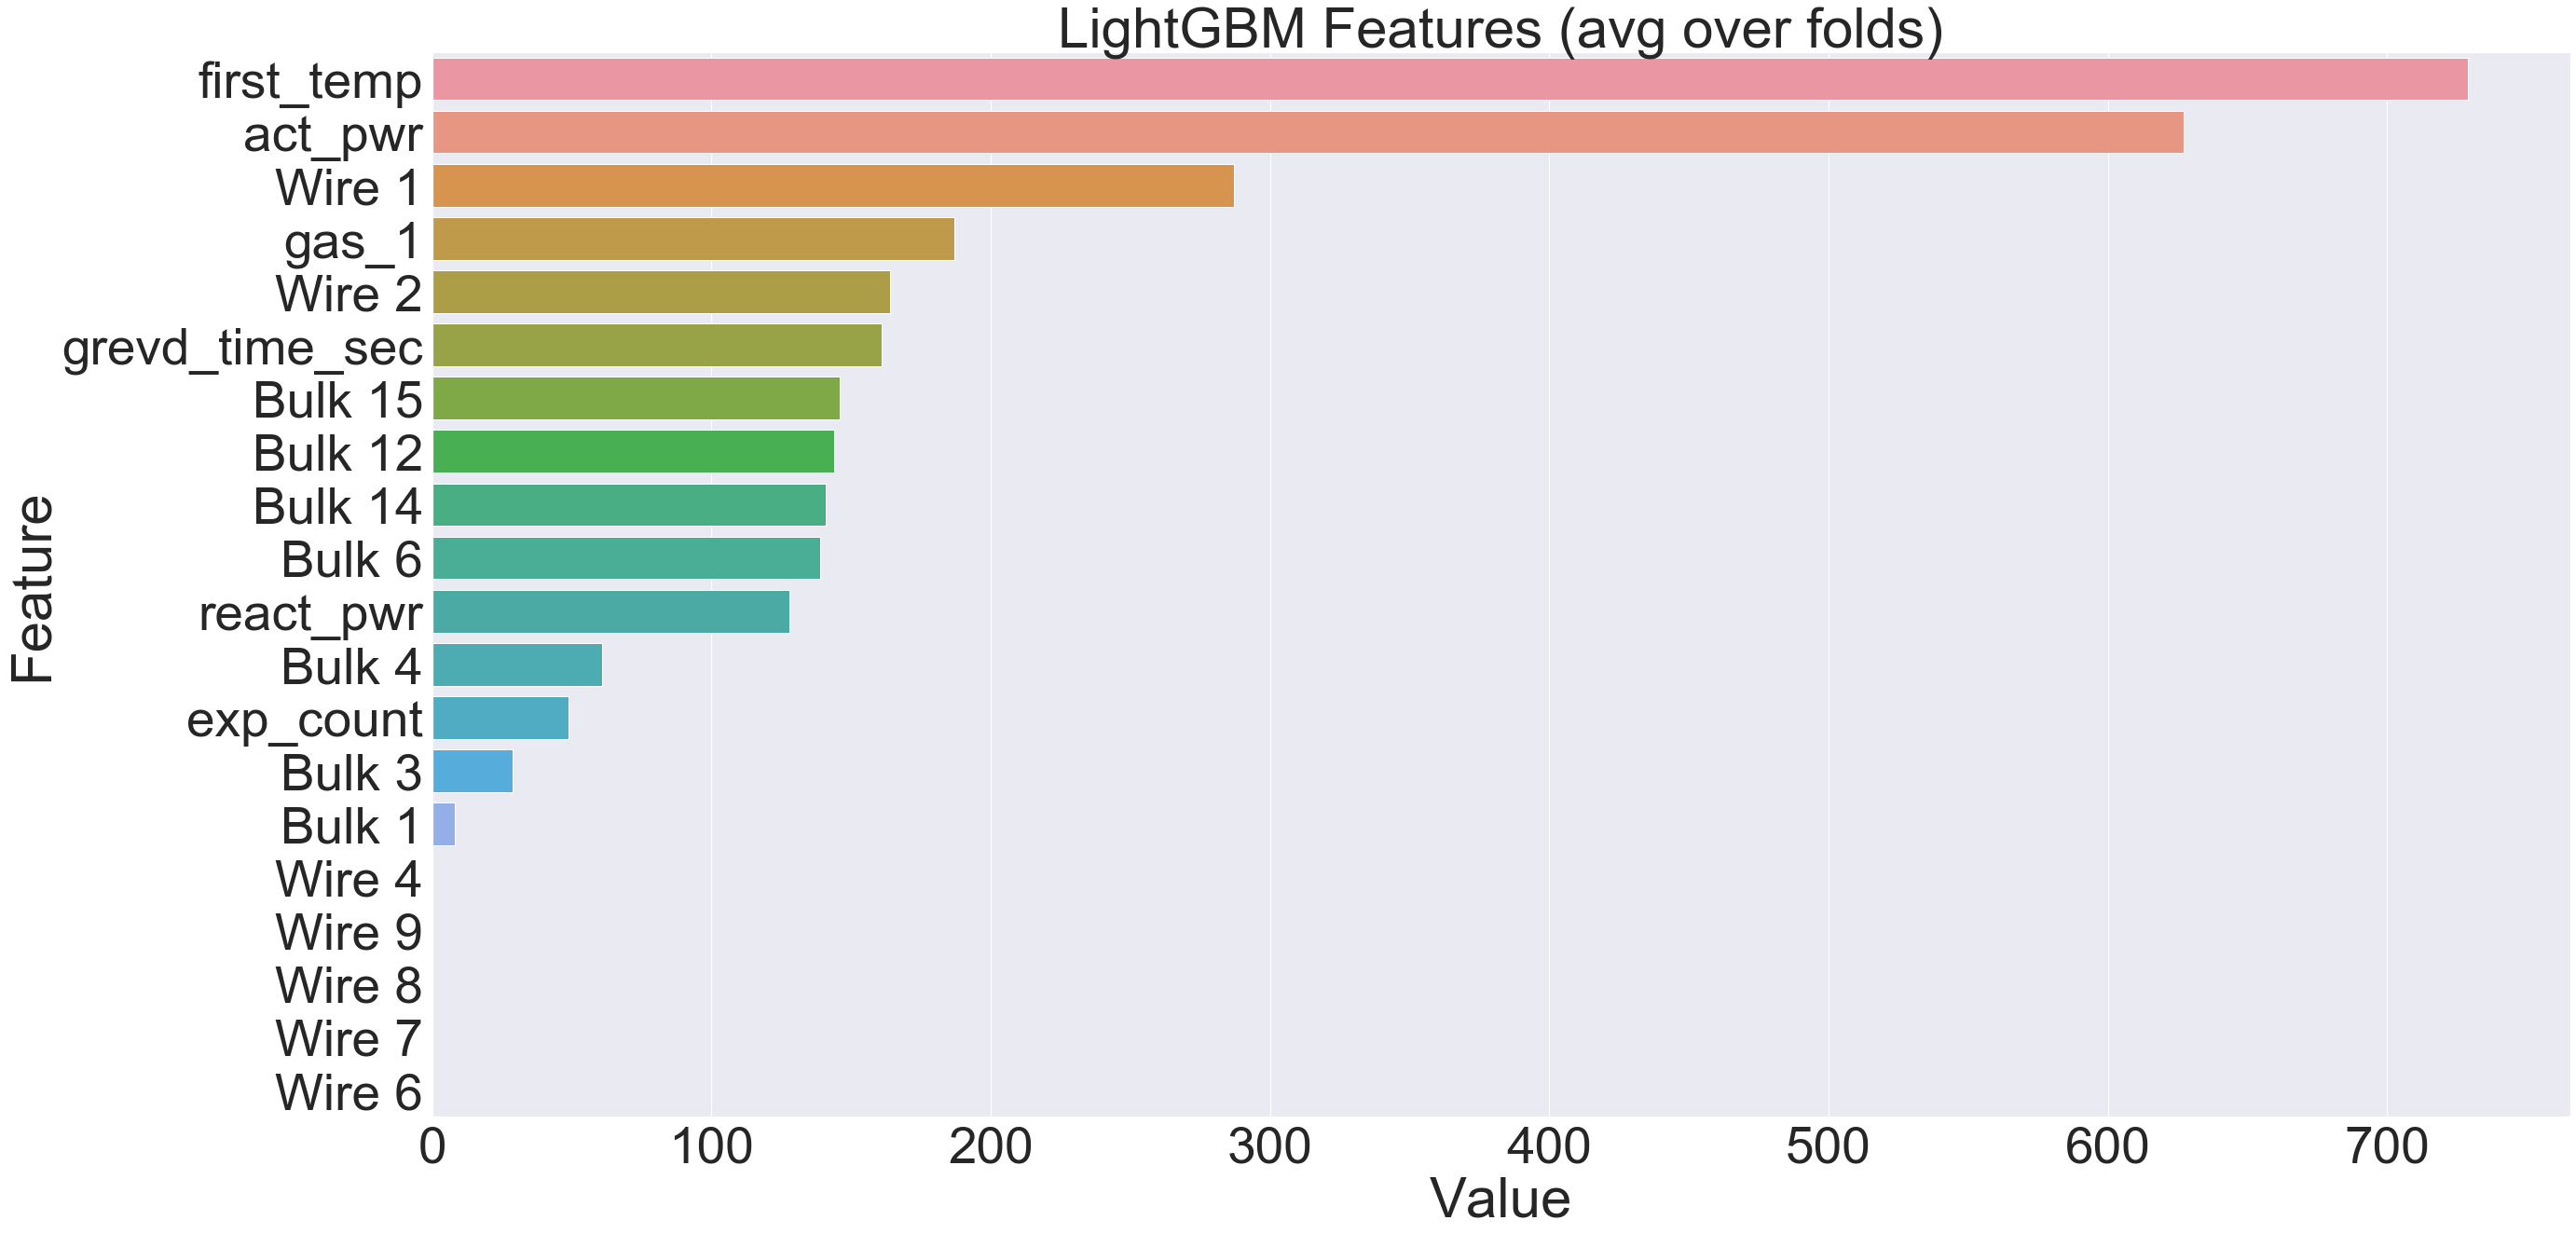

In [390]:
# Нарисуем графие
plotImp(gbm,features_train)

In [391]:
matrx.shape

(1782, 32)

In [392]:
features_train

,act_pwr,react_pwr,grevd_time_sec,exp_count,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas_1,first_temp
580,5.021668,3.615642,1202,5,0.0,0.0,0.0,100.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.707244,1555.0
1059,3.105400,2.089695,690,4,0.0,0.0,129.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.763947,1576.0
1031,2.941897,2.338350,792,4,0.0,0.0,0.0,0.0,0.0,70.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.152548,1572.0
2375,3.922034,2.758537,1026,5,0.0,0.0,0.0,220.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.398952,1583.0
932,2.848874,1.961643,653,4,0.0,0.0,199.0,0.0,28.0,0.0,...,20.207199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.978598,1575.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,2.808693,1.829581,716,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.437953,1571.0
677,1.966570,1.576476,545,4,0.0,0.0,0.0,0.0,0.0,90.0,...,51.332317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.532679,1631.0
516,1.854352,1.646553,580,4,0.0,0.0,0.0,0.0,0.0,27.0,...,51.030720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.280482,1597.0
2211,3.070003,2.038484,753,4,0.0,0.0,0.0,134.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.507683,1574.0


### LightGBM: Боевое обучение

In [393]:
lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression',
    'metric': {'mse'},
    'num_leaves': 31,
    'n_estimators':200,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9111111,
    'bagging_freq': 5,
    'verbose': 0,
    'reg_alpha':0.05,
    'reg_lambda':3,
    'n_jobs':400#,
    #'device':'gpu'
} 

In [394]:
%%time
print('-------Приступаю к обучению модели LightGBM-------')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=300,
                valid_sets=lgb_eval,
                early_stopping_rounds=50,
                )
print()

-------Приступаю к обучению модели LightGBM-------


/Users/u18272710/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 121.016
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 114.166
[3]	valid_0's l2: 109.631
[4]	valid_0's l2: 104.864
[5]	valid_0's l2: 101.867
[6]	valid_0's l2: 98.1707
[7]	valid_0's l2: 94.7461
[8]	valid_0's l2: 93.5559
[9]	valid_0's l2: 92.8967
[10]	valid_0's l2: 90.5512
[11]	valid_0's l2: 88.5572
[12]	valid_0's l2: 87.0262
[13]	valid_0's l2: 86.3346
[14]	valid_0's l2: 84.8124
[15]	valid_0's l2: 83.982
[16]	valid_0's l2: 82.317
[17]	valid_0's l2: 81.1954
[18]	valid_0's l2: 80.4852
[19]	valid_0's l2: 79.6348
[20]	valid_0's l2: 78.8214
[21]	valid_0's l2: 77.8644
[22]	valid_0's l2: 76.9668
[23]	valid_0's l2: 75.991
[24]	valid_0's l2: 75.4808
[25]	valid_0's l2: 75.5179
[26]	valid_0's l2: 75.4821
[27]	valid_0's l2: 74.748
[28]	valid_0's l2: 74.2007
[29]	valid_0's l2: 74.1685
[30]	valid_0's l2: 73.6197
[31]	valid_0's l2: 73.5293
[32]	valid_0's l2: 73.468
[33]	valid_0's l2: 73.44
[34]	valid_0's l2: 73.2465
[35]	valid_0's l2: 73.1787
[36]	valid

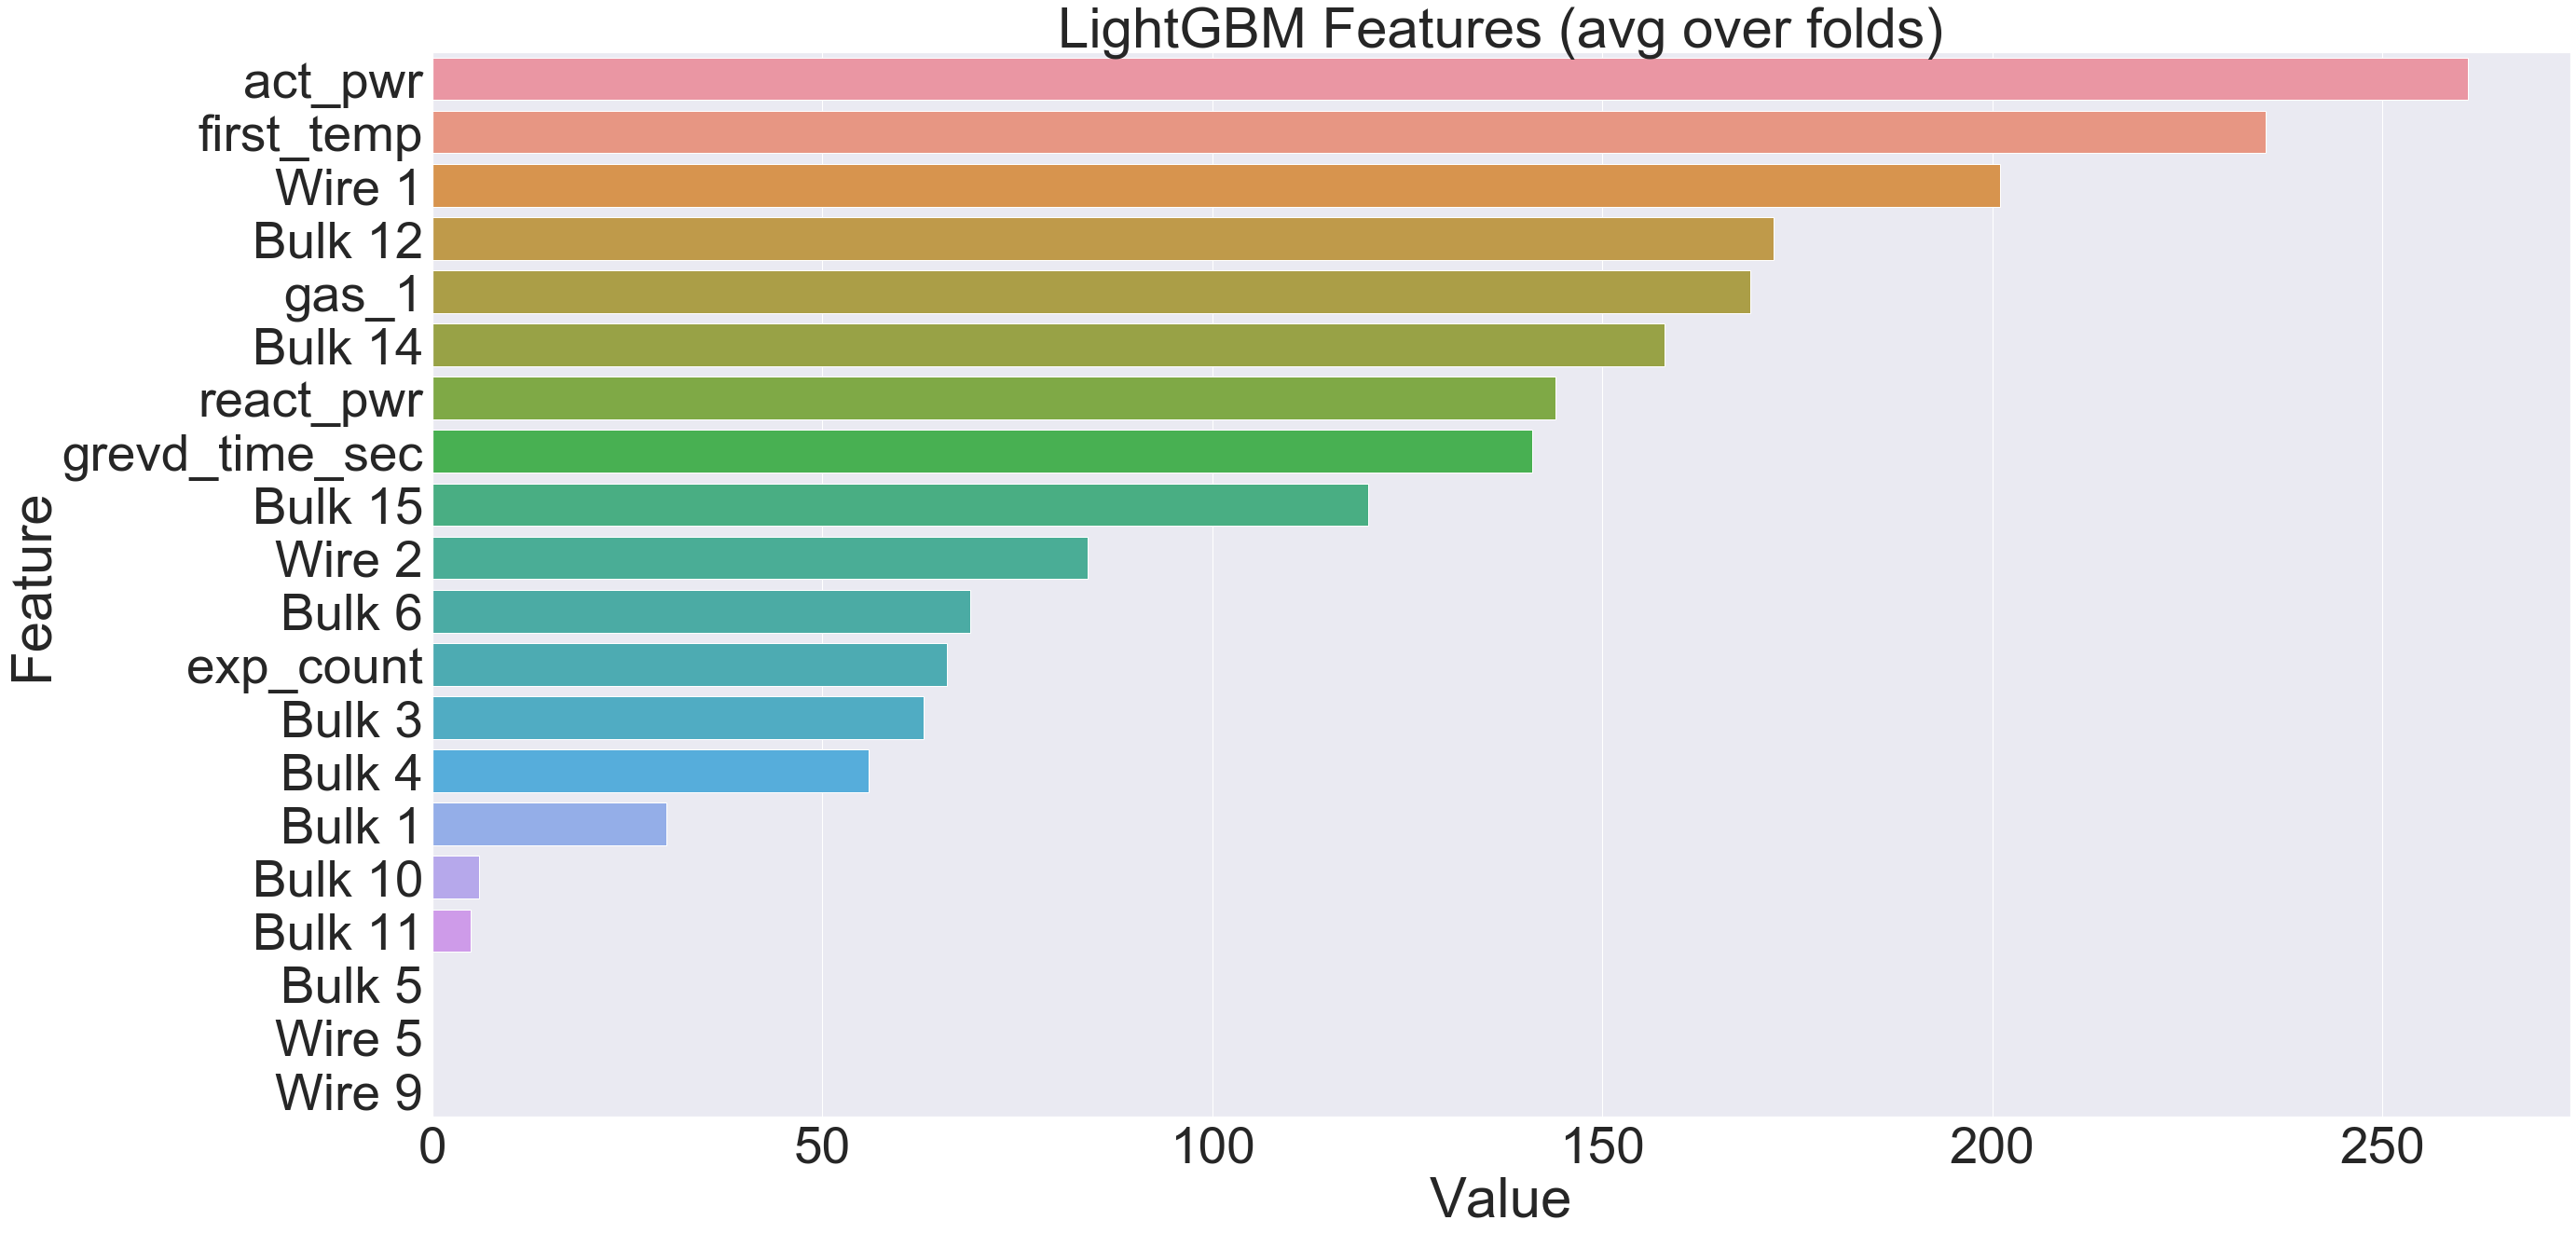

In [395]:
#проверим значимость на тестовой выборке
plotImp(gbm,features_test)

1. Активная мощность стала более значимой
2. Температура первого замера переместилась на второе место
3. Wire 1
4. По остальным, не входящим в топ 3 повысилась значимость

In [396]:
%%time
print('>>> Приступаю к предсказанию по модели')
pred_valid = gbm.predict(features_valid, num_iteration=gbm.best_iteration)
print('>>> Модель обучена')

>>> Приступаю к предсказанию по модели
>>> Модель обучена
CPU times: user 64.6 ms, sys: 255 ms, total: 320 ms
Wall time: 40.7 ms


In [397]:
%%time
pred_test = gbm.predict(features_test, num_iteration=gbm.best_iteration)
print()
print('>>> Тестовая выборка предсказана ---------')


>>> Тестовая выборка предсказана ---------
CPU times: user 25.5 ms, sys: 84.6 ms, total: 110 ms
Wall time: 15 ms


In [398]:
print('------------------MAE предсказания-------------------------------')
print('MAE test LIGHT GMB: >>', mean_absolute_error(target_test, pred_test), "<<")
print('MSE test LIGHT GMB: >>', mean_squared_error(target_test, pred_test), "<<")

------------------MAE предсказания-------------------------------
MAE test LIGHT GMB: >> 5.92489399265402 <<
MSE test LIGHT GMB: >> 58.92175405893732 <<


### CatBoost: разведка боем

In [399]:
%%time
#гиперпараметры пришлось положить вместе с обучением (все равно быстрее получается) 

#гиперпараметры
Catmodel = CatBoostRegressor(
    iterations=500,
    random_seed=456,
    learning_rate=0.01,
    early_stopping_rounds=500,
    loss_function='MAE',
    #depth=16,
    l2_leaf_reg=20
)

#приступаем к обучению

Catmodel.fit(
    features_train, target_train,
    eval_set=(features_valid, target_valid)
)
print()



0:	learn: 7.6690166	test: 8.1482672	best: 8.1482672 (0)	total: 61.8ms	remaining: 30.8s
1:	learn: 7.6524750	test: 8.1300426	best: 8.1300426 (1)	total: 64ms	remaining: 15.9s
2:	learn: 7.6390047	test: 8.1206241	best: 8.1206241 (2)	total: 66.1ms	remaining: 11s
3:	learn: 7.6190014	test: 8.0924740	best: 8.0924740 (3)	total: 68ms	remaining: 8.44s
4:	learn: 7.6016391	test: 8.0761085	best: 8.0761085 (4)	total: 69.8ms	remaining: 6.91s
5:	learn: 7.5839428	test: 8.0577056	best: 8.0577056 (5)	total: 71.5ms	remaining: 5.88s
6:	learn: 7.5684240	test: 8.0408758	best: 8.0408758 (6)	total: 73.4ms	remaining: 5.17s
7:	learn: 7.5495314	test: 8.0164015	best: 8.0164015 (7)	total: 75.9ms	remaining: 4.67s
8:	learn: 7.5295944	test: 7.9970341	best: 7.9970341 (8)	total: 78.2ms	remaining: 4.26s
9:	learn: 7.5166436	test: 7.9822595	best: 7.9822595 (9)	total: 80.9ms	remaining: 3.96s
10:	learn: 7.5036032	test: 7.9684540	best: 7.9684540 (10)	total: 82.9ms	remaining: 3.69s
11:	learn: 7.4856833	test: 7.9490917	best: 7.94

94:	learn: 6.4423104	test: 6.9083550	best: 6.9083550 (94)	total: 250ms	remaining: 1.06s
95:	learn: 6.4309033	test: 6.9012859	best: 6.9012859 (95)	total: 252ms	remaining: 1.06s
96:	learn: 6.4193148	test: 6.8937036	best: 6.8937036 (96)	total: 254ms	remaining: 1.06s
97:	learn: 6.4090903	test: 6.8875328	best: 6.8875328 (97)	total: 257ms	remaining: 1.05s
98:	learn: 6.4025184	test: 6.8814807	best: 6.8814807 (98)	total: 259ms	remaining: 1.05s
99:	learn: 6.3917816	test: 6.8712755	best: 6.8712755 (99)	total: 262ms	remaining: 1.05s
100:	learn: 6.3826019	test: 6.8634166	best: 6.8634166 (100)	total: 265ms	remaining: 1.04s
101:	learn: 6.3732754	test: 6.8559788	best: 6.8559788 (101)	total: 267ms	remaining: 1.04s
102:	learn: 6.3641374	test: 6.8479361	best: 6.8479361 (102)	total: 270ms	remaining: 1.04s
103:	learn: 6.3564250	test: 6.8430685	best: 6.8430685 (103)	total: 273ms	remaining: 1.04s
104:	learn: 6.3464955	test: 6.8358774	best: 6.8358774 (104)	total: 276ms	remaining: 1.04s
105:	learn: 6.3408508	

220:	learn: 5.6249693	test: 6.4380706	best: 6.4380706 (220)	total: 636ms	remaining: 803ms
221:	learn: 5.6207161	test: 6.4335680	best: 6.4335680 (221)	total: 642ms	remaining: 804ms
222:	learn: 5.6146505	test: 6.4343597	best: 6.4335680 (221)	total: 645ms	remaining: 802ms
223:	learn: 5.6105763	test: 6.4331892	best: 6.4331892 (223)	total: 650ms	remaining: 800ms
224:	learn: 5.6063107	test: 6.4296718	best: 6.4296718 (224)	total: 654ms	remaining: 799ms
225:	learn: 5.6020985	test: 6.4282719	best: 6.4282719 (225)	total: 657ms	remaining: 797ms
226:	learn: 5.5989108	test: 6.4260777	best: 6.4260777 (226)	total: 660ms	remaining: 794ms
227:	learn: 5.5957822	test: 6.4245143	best: 6.4245143 (227)	total: 663ms	remaining: 791ms
228:	learn: 5.5911765	test: 6.4213327	best: 6.4213327 (228)	total: 666ms	remaining: 788ms
229:	learn: 5.5870242	test: 6.4179679	best: 6.4179679 (229)	total: 668ms	remaining: 784ms
230:	learn: 5.5824932	test: 6.4160143	best: 6.4160143 (230)	total: 678ms	remaining: 790ms
231:	learn

386:	learn: 5.1307063	test: 6.1742394	best: 6.1742394 (386)	total: 1.01s	remaining: 295ms
387:	learn: 5.1282785	test: 6.1729638	best: 6.1729638 (387)	total: 1.01s	remaining: 292ms
388:	learn: 5.1258989	test: 6.1724480	best: 6.1724480 (388)	total: 1.01s	remaining: 290ms
389:	learn: 5.1245978	test: 6.1709401	best: 6.1709401 (389)	total: 1.02s	remaining: 287ms
390:	learn: 5.1214593	test: 6.1744071	best: 6.1709401 (389)	total: 1.02s	remaining: 284ms
391:	learn: 5.1188603	test: 6.1718730	best: 6.1709401 (389)	total: 1.02s	remaining: 282ms
392:	learn: 5.1166315	test: 6.1707174	best: 6.1707174 (392)	total: 1.03s	remaining: 279ms
393:	learn: 5.1151749	test: 6.1692355	best: 6.1692355 (393)	total: 1.03s	remaining: 277ms
394:	learn: 5.1135683	test: 6.1671615	best: 6.1671615 (394)	total: 1.03s	remaining: 274ms
395:	learn: 5.1109227	test: 6.1675120	best: 6.1671615 (394)	total: 1.03s	remaining: 272ms
396:	learn: 5.1087206	test: 6.1654363	best: 6.1654363 (396)	total: 1.04s	remaining: 269ms
397:	learn

In [400]:
%%time
#предсказываем!
prediction_test_ct = Catmodel.predict(features_test)

CPU times: user 8.52 ms, sys: 1.79 ms, total: 10.3 ms
Wall time: 8.16 ms


In [401]:
%%time
print(">>MAE TEST CATBOOST<<",mean_absolute_error(target_test, prediction_test_ct))
print(">>MSE TEST CATBOOST<<",mean_squared_error(target_test, prediction_test_ct))


>>MAE TEST CATBOOST<< 5.794889347922176
>>MSE TEST CATBOOST<< 62.53912124221987
CPU times: user 1.12 ms, sys: 672 µs, total: 1.8 ms
Wall time: 1.31 ms


### Результаты обучения

#### Лучшие гиперараметры для обучения

##### LightGBM

```python
params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression',
    'metric': {'mse'},
    'num_leaves': 31,
    'n_estimators':500,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9111111,
    'bagging_freq': 5,
    'verbose': 0,
    'reg_alpha':0.05,
    'reg_lambda':3,
    'n_jobs':1000#,
    #'device':'gpu'
} 

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=200,
                )

```

MAE test: 5.90934808168714 <br>
MSE test: 67.26745799140507 <br>
[461]	valid_0's l2: 42.6217 <br><br>

##### CatBoost
```python
Catmodel = CatBoostRegressor(
    iterations=500,
    random_seed=456,
    learning_rate=0.01,
    early_stopping_rounds=500,
    loss_function='MAE',
    l2_leaf_reg=20
)


Catmodel.fit(
    features_train, target_train,
    eval_set=(features_valid, target_valid)
)

```
<br>
MAE TEST CATBOOST: 5.8375231327114685<br>
MSE TEST CATBOOST: 69.37352284030796<br>
bestTest = 5.106429593<br>
bestIteration = 498<br>

#### Таблица скорости и качества моделей

In [403]:
tabledata = [["LGBM", "3min 22s", "17.8 ms", 69.67, 6.03],
             ["CatBoost", "12.3 s", "3.13 ms", 69.37, 5.84]]

fin_table = pd.DataFrame(tabledata, columns=["Модель", "T-обучения","T-предсказания","MSE(дополнительно)", "MAE (ЦЕЛЬ)"])
fin_table

,Модель,T-обучения,T-предсказания,MSE(дополнительно),MAE (ЦЕЛЬ)
0,LGBM,3min 22s,17.8 ms,69.67,6.03
1,CatBoost,12.3 s,3.13 ms,69.37,5.84


## Выводы
1. LightGBM показывает хороший результат, но обучается достаточно долго в сравнении с CatBoost.
2. Лучший результат скорость\качество показывает именно CatBoost.
3. LigthGBM стабильнее работает, потому что у меня на компе в анакоде Catboost так и не работает. Зато в DataSphere его не нужно перекомпилировать для работы с GPU, за что сервису спасибо, в отличие от GoogleCollab.
4. Почти получилось следовать плану за исключением:<br>
4.1 Я не делал масштабирование, но на практике в текущем проекте масштабирование не потребовалось, было бы полезно для моделей sklearn.<br>